# Confusion matrix assignment

## Continued work on Tanzania data set

### random grid search, over sampling, confusion matrix and ensemble model 

## All imports, load data, split into train and validation sets

In [288]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pprint import pprint

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = LOCAL

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

print(train.shape, val.shape, test.shape)

(47520, 41) (11880, 41) (14358, 40)


## Wrangle data, clean and feature engineering

In [289]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['pump_age'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    X = X.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    # create seasons based on month
    X['hot_dry'] = (X['month_recorded'] == 12) | (X['month_recorded'] < 3)     # Dec. - Feb.
    X['cool_dry'] = (X['month_recorded'] > 5) & (X['month_recorded'] < 11)     # Jun. - Oct
    X['light_rain'] = (X['month_recorded'] == 3) | (X['month_recorded'] == 11) # Mar. & Nov.
    X['heavy_rain'] = (X['month_recorded'] == 4) | (X['month_recorded'] == 5)  # Apr. & May
    
    # create installer features
    X['gov_installer'] = (X['installer'] == 'government')

    X['amount_tsh/pop'] = X['amount_tsh'] / X['population']
    
    return X

In [290]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

## split into 3 df's by status group to over sample minority class

In [291]:
functional = train[train['status_group'] == 'functional']
non_functional = train[train['status_group'] == 'non functional']
repair = train[train['status_group'] == 'functional needs repair']

functional.shape, non_functional.shape, repair.shape

((25807, 47), (18259, 47), (3454, 47))

In [309]:
repair_upsampled = resample(repair,
                            replace=True, # sample with replacement
                            n_samples=len(repair)*2, # double the size of needs repair
                            random_state=42) # reproducible results

repair_upsampled.shape

(6908, 47)

## Concat the 3 status group df's back into train

In [310]:
train = pd.concat([functional, non_functional, repair_upsampled])
train.shape

(50974, 47)

## Set target and features, then split into X features matrix and y target vector

In [311]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 300
categorical_features = cardinality[cardinality <= 300].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [312]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

## Create a pipeline with ordinal encoding, simple imputer using median, and random forest classifier

In [313]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=300,
                           min_samples_split=9,
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Train Accuracy 0.9326911758935928
Validation Accuracy 0.8106060606060606


## create random grid with various parameters for tuning

In [297]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


## encode data, use imputer to replace missing and prep for new random forest model

In [298]:
rf = RandomForestClassifier()

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

In [299]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

## Use random search grid to find best parameters for new random forest model

In [303]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3,
                              verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 66.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [304]:
pprint(rf_random.best_params_)

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}


## use parameters from random grid search in new random forest classifier model

In [316]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier( bootstrap= True, 
                            max_depth= 20, 
                            max_features= 'auto', 
                            min_samples_leaf= 2,
                            min_samples_split= 2, 
                            n_estimators= 1200,
                            n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_val_pred = pipeline.predict(X_val) 
y_pred = pipeline.predict(X_test)

Train Accuracy 0.9135833954565072
Validation Accuracy 0.809006734006734


## use results to create a confusion matrix and classification report

In [176]:
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[5909,   92,  451],
       [ 489,  233,  141],
       [ 990,   48, 3527]], dtype=int64)

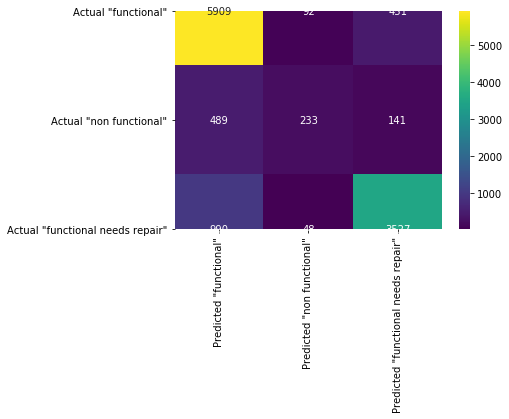

In [175]:
index_names = [f'Actual "{c}"' for c in y_val.unique()]
col_name = [f'Predicted "{c}"' for c in y_val.unique()]

df = pd.DataFrame(cm, columns=col_name, index=index_names)

sns.heatmap(df, cmap='viridis', annot=True, fmt='d')

In [317]:
print(classification_report(y_val, y_val_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6452
functional needs repair       0.53      0.37      0.44       863
         non functional       0.86      0.76      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.68      0.70     11880
           weighted avg       0.81      0.81      0.80     11880



## save the results as a new submission for kaggle comp

In [318]:
# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-rf-oversample.csv', index=False)

## Create an ensemble model using majority vote from previous submissions for a new submission

In [ ]:
files = [
    'submission-rf-features-randomGrid.csv',
    'submission-rf-features2.csv',
    'submission-rf-test.csv',
    'submission-rf-oversample.csv',
    'submission-rf-ordinal.csv',
    'rf_submission.csv'
]

target_name = 'status_group'

submissions = (pd.read_csv(file)[[target_name]] for file in files)

ensemble = pd.concat(submissions, axis='columns')

majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target_name] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)